#Libreria

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (
    Concatenate, Lambda, Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Conv2D, MaxPooling2D,
    AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization, ReLU, Input
)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers, regularizers, backend as K
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report,
    cohen_kappa_score, hamming_loss, log_loss, zero_one_loss, matthews_corrcoef, roc_curve, auc
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical, plot_model
from time import time
import datetime
from skimage.util.shape import view_as_blocks
import glob
import os
import random
import ntpath
import copy
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
print(sys.version)

3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Carga de datos

In [ ]:
# Load STFT data for each class
AD = np.load("/content/drive/MyDrive/BrainLat/EEGIMG/1_AD/stft.npy")  # Alzheimer's Disease (AD)
BV = np.load("/content/drive/MyDrive/BrainLat/EEGIMG/2_bvFTD/stft.npy")  # Behavioral variant Frontotemporal Dementia (bvFTD)
HC = np.load("/content/drive/MyDrive/BrainLat/EEGIMG/5_HC/stft.npy")  # Healthy Controls (HC)

# Concatenate features from all classes along the first axis
Features = np.concatenate((AD, BV, HC), axis=0)

# Create labels for each class and concatenate them
Labels = np.int32(np.concatenate((
    0 * np.ones((AD.shape[0])),  # Labels for AD
    1 * np.ones((BV.shape[0])),  # Labels for bvFTD
    2 * np.ones((HC.shape[0]))   # Labels for HC
), axis=0))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    Features, Labels, test_size=0.2, stratify=Labels, random_state=42
)

# Print the shapes of the training and test sets
print("Training data: ", X_train.shape)
print("Training labels: ", y_train.shape)
print("Test data: ", X_test.shape)
print("Test labels: ", y_test.shape)

# Convert labels to categorical format for use with neural networks
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

#Funciones e hiperFunciones

In [ ]:
def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
    # Squeeze: Global Average Pooling on the input layer
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)

    # Excitation: Two dense layers with different activations
    excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(out_dim, activation='sigmoid')(excitation)

    # Reshape excitation to match input dimensions
    excitation = tf.reshape(excitation, [-1, 1, 1, out_dim])

    # Scale: Element-wise multiplication of input and excitation
    scale = tf.keras.layers.multiply([input_layer, excitation])

    if conv:
        # Shortcut path with convolution and batch normalization if conv is True
        shortcut = tf.keras.layers.Conv2D(out_dim, kernel_size=1, strides=1,
                                          padding='same', kernel_initializer='he_normal')(input_layer)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    else:
        # Shortcut path is the input layer itself if conv is False
        shortcut = input_layer

    # Output is the addition of the shortcut and scaled input
    out = tf.keras.layers.add([shortcut, scale])

    return out

def sreLu(input):
    # Custom ReLU activation with a specified negative slope and no threshold
    return ReLU(negative_slope=0.1, threshold=0)(input)

def sConv(input, parameters, size, nstrides):
    # Convolutional layer with specified parameters, kernel size, strides, and regularization
    return Conv2D(parameters, (size, size), strides=(nstrides, nstrides), padding="same",
                  kernel_initializer='glorot_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                  bias_regularizer=tf.keras.regularizers.l2(0.0001))(input)

def sBN(input):
    # Batch normalization with specified momentum and epsilon
    return tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True,
                                              scale=True, trainable=True, fused=None,
                                              renorm=False, renorm_clipping=None,
                                              renorm_momentum=0.4, adjustment=None)(input)

def sGlobal_Avg_Pooling(input):
    # Global average pooling layer
    return tf.keras.layers.GlobalAveragePooling2D()(input)

def sDense(input, n_units, activate_c):
    # Dense layer with specified number of units and activation function
    return tf.keras.layers.Dense(n_units, activation=activate_c)(input)

def smultiply(input_1, input_2):
    # Element-wise multiplication of two inputs
    return tf.keras.layers.multiply([input_1, input_2])

def sadd(input_1, input_2):
    # Element-wise addition of two inputs
    return tf.keras.layers.add([input_1, input_2])

# Initial learning rate for the optimizer
initial_learning_rate = 0.001

# Learning rate schedule with exponential decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#Bloques TF


In [ ]:
def Block_1(input, parameter):
    # First block with convolution, batch normalization, and custom ReLU activation
    output = sConv(input, parameter, 3, 1)  # Convolutional layer
    output = sBN(output)  # Batch normalization
    output = sreLu(output)  # Custom ReLU activation
    return output

def SE_Block(input, out_dim, ratio):
    # Squeeze-and-Excitation block
    output = sGlobal_Avg_Pooling(input)  # Global average pooling
    output = sDense(output, out_dim / ratio, 'relu')  # Dense layer with ReLU activation
    output = sDense(output, out_dim, 'sigmoid')  # Dense layer with sigmoid activation
    return output

def Block_3(input, parameter):
    # Third block with multiple layers and squeeze-and-excitation
    addition = sConv(input, parameter, 1, 2)  # Convolutional layer for shortcut path
    addition = sBN(addition)  # Batch normalization for shortcut path

    output = sConv(input, parameter, 3, 2)  # Convolutional layer
    output = sBN(output)  # Batch normalization
    output = sreLu(output)  # Custom ReLU activation

    output = sConv(output, parameter, 3, 1)  # Another convolutional layer
    output = sBN(output)  # Batch normalization

    multiplier = SE_Block(output, parameter, parameter)  # Squeeze-and-Excitation block
    output = smultiply(multiplier, output)  # Element-wise multiplication with SE block output
    output = sadd(output, addition)  # Element-wise addition with shortcut path

    return output

def Block_4(input, parameter):
    # Fourth block with a nested Block_1 and additional layers
    output = Block_1(input, parameter)  # Nested Block_1
    output = sConv(input, parameter, 3, 1)  # Convolutional layer
    output = sBN(output)  # Batch normalization

    return output

#Hiperparametros SpectroCVT-Net

In [ ]:
# OPTIMIZER PARAMETERS
LEARNING_RATE_2 = 1e-3  # Learning rate for the optimizer
WEIGHT_DECAY_2 = 1e-4  # Weight decay for regularization

# IMAGE AND PATCH PARAMETERS
IMAGE_SIZE_2 = 13  # The input images will be resized to this size (13x13 pixels)
PATCH_SIZE_2 = 11  # Size of the patches to be extracted from the input images (11x11 pixels)
NUM_PATCHES_2 = (IMAGE_SIZE_2 // PATCH_SIZE_2) ** 2  # Number of patches per image
print(NUM_PATCHES_2)

# VISION TRANSFORMER ARCHITECTURE PARAMETERS
LAYER_NORM_EPS_2 = 1e-6  # Epsilon value for layer normalization
PROJECTION_DIM_2 = 128  # Dimensionality of the projection space
NUM_HEADS_2 = 4  # Number of attention heads in the multi-head attention layer
NUM_LAYERS_2 = 4  # Number of transformer layers
MLP_UNITS_2 = [
    PROJECTION_DIM_2 * 2,  # Number of units in the first layer of the MLP
    PROJECTION_DIM_2       # Number of units in the second layer of the MLP
]

1


#Convolutional Vision Transformer

In [ ]:
def position_embedding(projected_patches, num_patches=NUM_PATCHES_2, projection_dim=PROJECTION_DIM_2):
    # Build the positions: create a range of position indices from 0 to num_patches - 1
    positions = tf.range(start=0, limit=num_patches, delta=1)

    # Encode the positions with an Embedding layer
    encoded_positions = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)

    # Add encoded positions to the projected patches
    return projected_patches + encoded_positions

def mlp(x, dropout_rate, hidden_units):
    # Iterate over the hidden units and add Dense => Dropout layers
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Dense layer with GELU activation
        x = layers.Dropout(dropout_rate)(x)  # Dropout layer
    return x

def transformer_2(encoded_patches):
    # Apply layer normalization
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(encoded_patches)

    # Multi-Head Self Attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS_2, key_dim=PROJECTION_DIM_2, dropout=0.1
    )(x1, x1)

    # Skip connection
    x2 = layers.Add()([attention_output, encoded_patches])

    # Apply layer normalization again
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(x2)

    # Apply MLP layer
    x4 = mlp(x3, hidden_units=MLP_UNITS_2, dropout_rate=0.1)

    # Second skip connection
    encoded_patches = layers.Add()([x4, x2])
    return encoded_patches

def Transform_sh_2(inputs):
    # Apply squeeze and excitation layer
    inputs1 = squeeze_excitation_layer(inputs, out_dim=512, ratio=32.0, conv=False)
    print(inputs1.shape)

    # Project input patches using a Conv2D layer
    projected_patches = layers.Conv2D(
        filters=PROJECTION_DIM_2,
        kernel_size=(PATCH_SIZE_2, PATCH_SIZE_2),
        strides=(PATCH_SIZE_2, PATCH_SIZE_2),
        padding="VALID",
    )(inputs1)

    # Get the shape of the projected patches
    _, h, w, c = projected_patches.shape

    # Reshape the projected patches
    projected_patches = layers.Reshape((h * w, c))(projected_patches)  # (B, number_patches, projection_dim)

    # Add positional embeddings to the projected patches
    encoded_patches = position_embedding(projected_patches)  # (B, number_patches, projection_dim)

    # Apply dropout
    encoded_patches = layers.Dropout(0.1)(encoded_patches)

    # Iterate over the number of layers and stack transformer blocks
    for i in range(NUM_LAYERS_2):
        # Add a transformer block
        encoded_patches = transformer_2(encoded_patches)

    return encoded_patches

#Modelo Viejo


In [ ]:
def new_archv():
    # Clear any existing TensorFlow graphs
    tf.keras.backend.clear_session()

    # Define the input layer with shape (224, 224, 128)
    inputs = tf.keras.Input(shape=(224, 224, 128), name="input_1")

    # Apply Block_3 with 64 filters
    layers = Block_3(inputs, 64)

    # Apply Block_3 for 64, 128, and 256 filters sequentially
    for i in [64, 128, 256]:
        layers = Block_3(layers, i)

    # Apply Block_4 with 512 filters
    layers = Block_4(layers, 512)

    print(layers.shape)

    # Apply the Transform_sh_2 function (Vision Transformer part)
    CVT1 = Transform_sh_2(layers)

    # Apply layer normalization
    representation = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS_2)(CVT1)

    # Apply global average pooling
    representation = tf.keras.layers.GlobalAvgPool1D()(representation)

    # --------------------------------------------------- End of Transformer 2 --------------------------------------------------- #

    # Fully connected (FC) layers
    layers = Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                   bias_regularizer=tf.keras.regularizers.l2(0.0001))(representation)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = BatchNormalization()(layers)

    layers = Dense(64, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                   bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = BatchNormalization()(layers)

    layers = Dense(32, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                   bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = BatchNormalization()(layers)

    # Output layer with softmax activation for classification into 3 classes
    predictions = Dense(3, activation="softmax", name="output_1")(layers)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    # Compile the model if the compile flag is set
    if compile:
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        print("Transformer_create")

    return model

In [ ]:
#Compile de model
modelv = new_archv()

#Entranimiento y metricas

In [ ]:
# Define the base paths for logging and image saving
path_log_base = '/content/logs'
path_img_base = '/content/images'

# Create directories if they do not exist
if not os.path.exists(path_log_base):
    os.makedirs(path_log_base)
if not os.path.exists(path_img_base):
    os.makedirs(path_img_base)

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    # Record the start time for training duration calculation
    start_time = tm.time()

    # Define the log directory with a timestamp for TensorBoard logs
    log_dir = path_log_base + "/" + model_name + "_" + str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":", "-"))

    # Create a TensorBoard callback
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

    # Define the file path for model checkpoints
    filepath = log_dir + "/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

    # Reset model states before training
    model.reset_states()

    # Evaluate the model on test, train, and validation datasets before training
    global lossTEST, accuracyTEST, lossTRAIN, accuracyTRAIN, lossVALID, accuracyVALID
    lossTEST, accuracyTEST = model.evaluate(X_test, y_test, verbose=None)
    lossTRAIN, accuracyTRAIN = model.evaluate(X_train, y_train, verbose=None)
    lossVALID, accuracyVALID = model.evaluate(X_valid, y_valid, verbose=None)

    # Global variables for storing model history and details
    global history, model_Name, log_Dir
    model_Name = model_name
    log_Dir = log_dir

    print("Starting the training...")

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs,
                        callbacks=[tensorboard, checkpoint],
                        batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=2)

    # Evaluate the model on the test set after training
    metrics = model.evaluate(X_test, y_test, verbose=0)

    # Calculate and print the time taken for training
    TIME = tm.time() - start_time
    print("Time " + model_name + " = %s [seconds]" % TIME)

    # Print the log directory and call the function to log final results
    print("\n")
    print(log_dir)
    Final_Results_Test(log_dir)

    # Return a dictionary of the model metrics
    return {k: v for k, v in zip(model.metrics_names, metrics)}

def Final_Results_Test(PATH_trained_models):
    # Initialize lists for accuracy and loss
    global AccTest, LossTest
    AccTest = []
    LossTest = []

    # Initialize variables for best accuracy and corresponding loss
    B_accuracy = 0  # B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        # Skip 'train' and 'validation' files
        if filename != 'train' and filename != 'validation':
            print(filename)

            # Load the model from file
            model = tf.keras.models.load_model(PATH_trained_models + '/' + filename, custom_objects={'Tanh3': Tanh3})

            # Evaluate the loaded model on the test set
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f'Loss={loss:.4f} and Accuracy={accuracy:.4f}' + '\n')

            # Store the accuracy and loss
            BandAccTest = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)
            LossTest.append(BandLossTest)

            # Update best accuracy and corresponding loss
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    # Print the best model results
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} and Accuracy={B_accuracy:.4f}' + '\n')

In [ ]:
# Train the model with the specified parameters
# Train the model with the specified parameters
# Arguments:
# - modelv: The model to be trained.
# - X_train: Training features.
# - y_train: Training labels.
# - X_test: Testing features (used for both validation and testing here).
# - y_test: Testing labels (used for both validation and testing here).
# - batch_size: Number of samples per gradient update.
# - epochs: Number of epochs to train the model.
# - model_name: Name for the model, used to generate log and checkpoint filenames.
train(modelv, X_train, y_train, X_test, y_test, X_test, y_test, batch_size=128, epochs=500, model_name="Model_Transformer_EEG")

Starting the training...
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 - 33s - loss: 1.9942 - accuracy: 0.2059 - val_loss: 3.0563 - val_accuracy: 0.3889 - 33s/epoch - 33s/step
Epoch 2/500
1/1 - 3s - loss: 1.1107 - accuracy: 0.6176 - val_loss: 3.0914 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 3/500
1/1 - 3s - loss: 0.8511 - accuracy: 0.6765 - val_loss: 3.2804 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 4/500
1/1 - 3s - loss: 0.7690 - accuracy: 0.7353 - val_loss: 3.2190 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 5/500
1/1 - 3s - loss: 0.6863 - accuracy: 0.8088 - val_loss: 3.2968 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 6/500
1/1 - 3s - loss: 0.6825 - accuracy: 0.7500 - val_loss: 3.3494 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 7/500
1/1 - 4s - loss: 0.6343 - accuracy: 0.7941 - val_loss: 3.3900 - val_accuracy: 0.3889 - 4s/epoch - 4s/step
Epoch 8/500
1/1 - 3s - loss: 0.5498 - accuracy: 0.8676 - val_loss: 3.4350 - val_accuracy: 0.3889 - 3s/epoch - 3s/step
Epoch 9/500
1/1 - 3s - loss: 0.6446 - accuracy: 0.7794 - val_loss

{'loss': 1.7733736038208008, 'accuracy': 0.7777777910232544}

In [ ]:
#Load the best epoch
model2=load_model("/content/logs/Model_Transformer_EEG_2024-04-19_06-25-56/saved-model-073-0.8889.hdf5")

In [ ]:
# Make predictions on the test set using the trained model
y_pred = model2.predict(X_test)  # Predict class probabilities for the test data

# Convert predictions to categorical format
# np.argmax extracts the class with the highest probability
# to_categorical converts these class indices to one-hot encoded vectors
y_pred = to_categorical(np.argmax(y_pred, axis=1), num_classes=3)

# Calculate performance metrics
# Accuracy: Proportion of correctly classified instances
accuracy = Accuracy()(y_test, y_pred).numpy()
# Precision: Proportion of true positive instances among the predicted positives
precision = Precision()(y_test, y_pred).numpy()
# Recall: Proportion of true positive instances among the actual positives
recall = Recall()(y_test, y_pred).numpy()
# AUC: Area under the ROC curve, representing the model's ability to discriminate between classes
auc = AUC()(y_test, y_pred).numpy()

# Print out the performance metrics
print("The model's accuracy is: ", accuracy)
print("The model's precision metric is: ", precision)
print("The model's recall metric is: ", recall)
print("The model's AUC is: ", auc)

In [ ]:
# Convert the one-hot encoded true labels to class indices if necessary
y_true = np.argmax(y_test, axis=1)  # Extract class indices from one-hot encoded y_test

# Convert the one-hot encoded predicted labels to class indices if necessary
y_pred_classes = np.argmax(y_pred, axis=1)  # Extract class indices from one-hot encoded y_pred

# Calculate the confusion matrix
# Confusion matrix summarizes the performance of the classification model
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Matriz de Confusión:
[[6 1 0]
 [1 3 0]
 [0 0 7]]


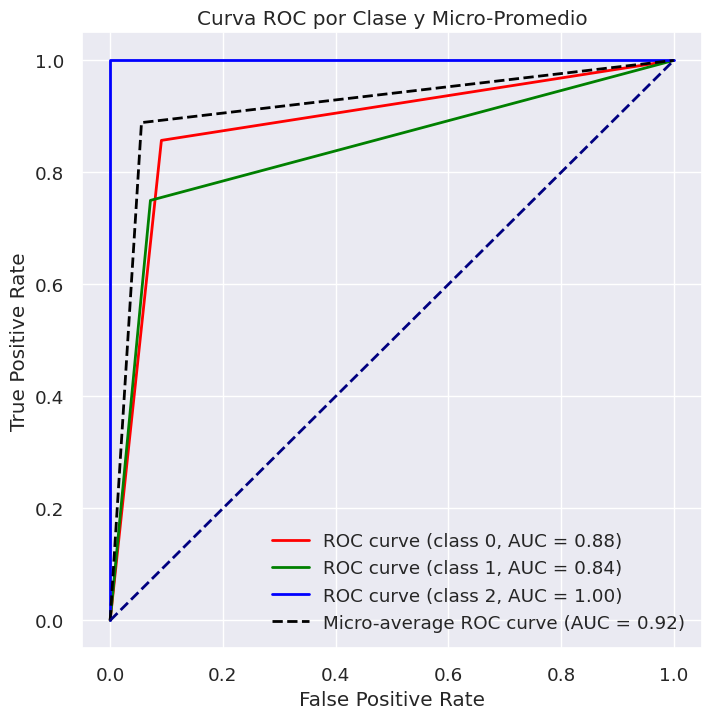

In [ ]:
# Convert the one-hot encoded true labels to class indices if necessary
y_true = np.argmax(y_test, axis=1)  # Extract class indices from one-hot encoded y_test

# Transform the predicted class indices to one-hot encoded format
n_classes = len(np.unique(y_true))  # Number of unique classes
y_probs = label_binarize(y_pred.argmax(axis=1), classes=range(n_classes))  # Convert y_pred to one-hot format

# Calculate ROC curve and AUC for each class
fpr = dict()  # False Positive Rates
tpr = dict()  # True Positive Rates
roc_auc = dict()  # AUC values
for i in range(n_classes):
    # Compute ROC curve and AUC for class i
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and AUC
# Flatten the true labels and predicted probabilities
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_true, classes=range(n_classes)).ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 8))
colors = ['red', 'green', 'blue']  # Colors for each class
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class and Micro-Average')
plt.legend(loc='lower right')
plt.show()

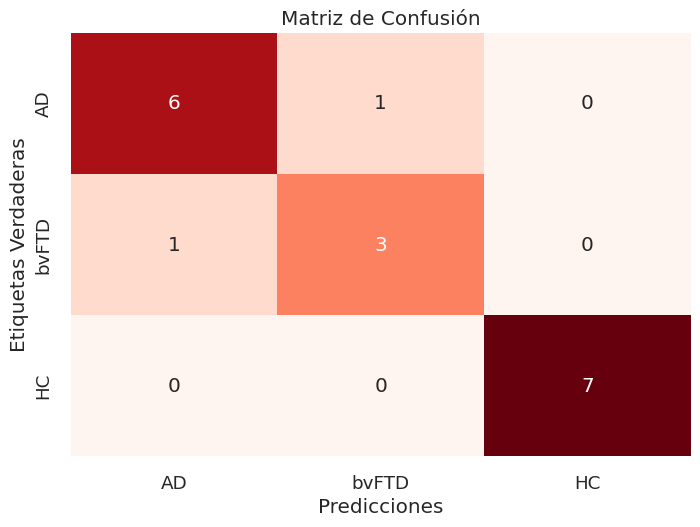

In [ ]:
# Define class labels for the confusion matrix
classes = ["AD", "bvFTD", "HC"]

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predictions')  # Label for the x-axis
plt.ylabel('True Labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

Text(58.388888888888886, 0.5, 'Etiquetas Verdaderas')

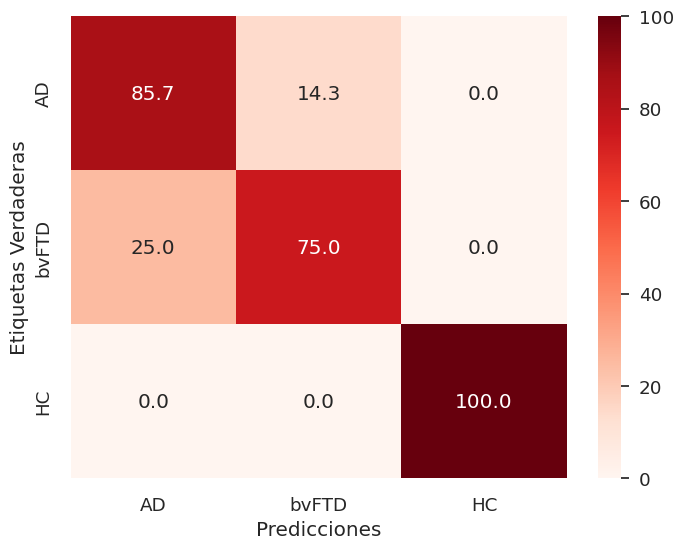

In [ ]:
# Convert the confusion matrix to percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Set the font scale for better readability
sns.set(font_scale=1.2)

# Create a figure with specified size
plt.figure(figsize=(8, 6))

# Plot the confusion matrix with percentages
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Reds', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predictions')  # Label for the x-axis
plt.ylabel('True Labels')  # Label for the y-axis
plt.title('Confusion Matrix with Percentages')  # Title of the plot
plt.show()  # Display the plot

In [ ]:
# Predicción del modelo sobre el conjunto de test
y_pred = model2.predict(X_test)

# Convertir las predicciones de categorías one-hot a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir las etiquetas verdaderas de categorías one-hot a etiquetas de clase si es necesario
y_true = np.argmax(y_test, axis=1)

# Generar el informe de clasificación
# `target_names` especifica los nombres de las clases para que aparezcan en el informe
report = classification_report(y_true, y_pred_classes, target_names=['AD', 'bvFTD', 'HC'])

# Imprimir el informe de clasificación
print(report)

1/1 [==============================] - 1s 518ms/step
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86         7
       bvFTD       0.75      0.75      0.75         4
          HC       1.00      1.00      1.00         7

    accuracy                           0.89        18
   macro avg       0.87      0.87      0.87        18
weighted avg       0.89      0.89      0.89        18

